In [41]:
import glob
import math
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
import numpy as np
from keras import Model
from keras.layers import Embedding, Dense, Flatten, Input
from keras import Sequential
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from termcolor import colored
from matplotlib.lines import Line2D

# Creating the Ingredients Dictionary and the dataset

Data structure used for indexing:
* __id_ingredients__ = dictionary in which each ingredient name is associate with a unique identifiers, which is also the index that has to be set to one in the dataset if a dishes contained that ingredient

Data structure used for training purposes:
* __dataset__ = list of dishes in which each of them is represented as a set of ingredients


Data structures used for testing purposes:
* __datasets_cuisine__ = dict in which the keys are the names of the cuisines and the values are the lists of dishes (belonging to that cuisine) in which each of them is represented as a set of ingredients

* __rice_dataset__ = list of dishes that contains rice, in which each of them is represented as a set of ingredients

* __disches__ = dict with the following structure:
<pre>
{
    cuisine-name-1: {
        dish-1: sparse vector of dish 1,   
        dish-2: sparse vector of dish 2,  
        ...                                   
        dish-n: sparse vector of dish n,  
      },   
    ...   
    cuisine-name-m: {
        dish-1: sparse vector of dish 1,
        dish-2: sparse vector of dish 2, 
        ...  
        dish-k: sparse vector of dish k,
     },       
}
</pre>


In [42]:
id_ingredients = {}
id_traker = 0
count = 0
for file in glob.glob("./data/DetasetRecepies/*.csv"):
    with open(file) as recipes:
        for line in recipes:
            recipe = line.split(";")[:-1]
            name = recipe[0]
            ingrs = recipe[1:]
            for ingr in ingrs:
                key = ingr
                if not(key in id_ingredients):
                    id_ingredients[key] = id_traker
                    id_traker += 1
                #else:
                #    id_ingredients[key] += 1
            if count % 100 == 0:
                print(count, end=", ")
            count += 1

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 

In [43]:
dataset = []
labels = []
datasets_cuisine = {}
rice_dataset = []
dishes = {}

for file in glob.glob("./data/DetasetRecepies/*.csv"):
    
    cuisine = file.split("/")[-1].split(".")[0]
    dishes[cuisine] = {}
    with open(file) as recipes:
        for line in recipes:
            # Initializing row
            row = list(np.zeros(len(id_ingredients)))
            
            # Extracting information from text
            recipy = line.split(";")[:-1]
            name = recipy[0]
            ingrs = recipy[1:]
            
            
            # Create sparse vector______________________
            # N.B. The vector is not one hot because 
            #      one dish contain more then one
            #      ingredients!
            for i in range(len(ingrs)):
                row[id_ingredients[ingrs[i]]] = 1
            row = np.array(row, dtype='int32')
            #___________________________________________
            
            # Update dataset____________________________
            dataset.append(row)
            labels.append(cuisine)
            #___________________________________________
            
            # Update datasets_cuisine___________________
            if cuisine in datasets_cuisine:
                datasets_cuisine[cuisine].append(row)
            else:
                datasets_cuisine[cuisine] = []
                datasets_cuisine[cuisine].append(row)
            #____________________________________________
            
            # Update ingrs_dataset_______________________
            if ("Rice" in line) or ("rice" in line):
                rice_dataset.append(row)
            #____________________________________________
            
            # Update dishes______________________________
            count = 1
            while name in dishes:
                name = name + str(count)
                count += 1
            dishes[cuisine][name] = row
            #____________________________________________
            
            
# Cast dataset to numpy.ndarray
dataset = np.array(dataset, dtype='int32')

# Cast datasets_cuisine to numpy.ndarray
for cuisine in datasets_cuisine:
    datasets_cuisine[cuisine] = np.array(datasets_cuisine[cuisine], dtype='int32')
    
# Cast rice_dataset to numpy.ndarray
rice_dataset = np.array(rice_dataset, dtype='int32')



# Defining ad training Word2vec

In [44]:
num_of_ingrs = len(id_ingredients)

input_img = Input(shape=(num_of_ingrs,))
encoded = Dense(50, activation='relu')(input_img)
decoded = Dense(num_of_ingrs, activation='sigmoid')(encoded)
word2vec = Model(input_img, decoded)

word2vec.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

word2vec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1218)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                60950     
_________________________________________________________________
dense_4 (Dense)              (None, 1218)              62118     
Total params: 123,068
Trainable params: 123,068
Non-trainable params: 0
_________________________________________________________________


In [8]:
word2vec.fit(dataset, dataset, epochs=5, verbose=1)

Epoch 1/5
1955/1955 [==============================] - 1s 356us/step - loss: 0.4651 - acc: 0.9405
Epoch 2/5
1955/1955 [==============================] - 0s 173us/step - loss: 0.0872 - acc: 0.9901
Epoch 3/5
1955/1955 [==============================] - 0s 175us/step - loss: 0.0581 - acc: 0.9902
Epoch 4/5
1955/1955 [==============================] - 0s 176us/step - loss: 0.0528 - acc: 0.9902
Epoch 5/5
1955/1955 [==============================] - 0s 170us/step - loss: 0.0504 - acc: 0.9901


In [10]:
word2vec.save_weights("./data/auto_enconder.h5")

In [45]:
#word2vec.load_weights("./data/auto_enconder.h5")

# Using word2vec for embedding

In [46]:
def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False

# Removing Decoder layer
pop_layer(word2vec)
embedder = Model(inputs=word2vec.input, outputs=word2vec.layers[-1].output)

In [9]:
# Serialize all the dishes
for cuisine in dishes:
    file = open("./re_embeddings/" + cuisine + ".csv", "w")
    for dish in dishes[cuisine]:
        embedding = str(list(embedder.predict(np.array([dishes[cuisine][dish]], dtype='int32'))[0]))[1:-1]
        
        file.write(dish + "; " + embedding.replace(",", ";") + "\n")
    
        

## Feature Reduction using PCA

In [10]:
output = embedder.predict(dataset)
pca = PCA(n_components=2)
pca.fit(output)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Plot all dishes

1955


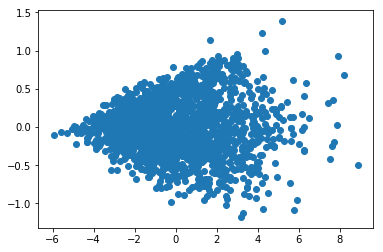

In [11]:
points = pca.transform(output)
x = [point[0] for point in points] 
y = [point[1] for point in points] 
print(len(x))
plt.scatter(x,y)

### Plot dishes for cuisine

In [12]:
points_for_cuisine = {}
for cuisine in datasets_cuisine:
    output_cuisine = embedder.predict(datasets_cuisine[cuisine])
    points = pca.transform(output_cuisine)
    points_for_cuisine[cuisine] = points

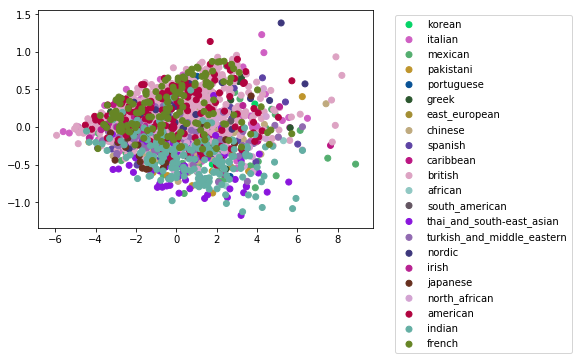

In [13]:
for cuisine in points_for_cuisine:
    points = points_for_cuisine[cuisine]
    colors = []
    color = np.random.rand(3)
    for i in range(len(points)):
        colors.append(color)
    x = [point[0] for point in points] 
    y = [point[1] for point in points] 
    plt.scatter(x,y,c=colors, label=cuisine)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
    

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

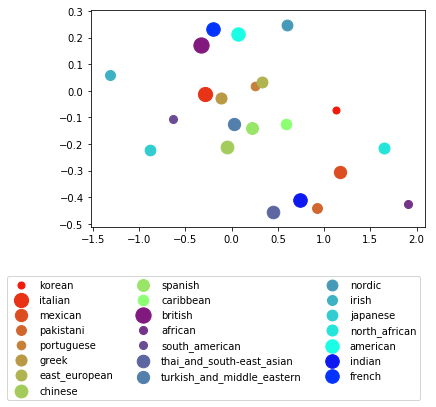

In [28]:
# Plot the mean point of the dishes of each cuisine

r = 1
g = 0
b = 0
for cuisine in points_for_cuisine:
    points = points_for_cuisine[cuisine]
    #color = np.random.rand(3)
    
    r -= 0.045
    g = (g+0.1)%1
    b += 0.045
    
    color = [r, g, b]
    x = np.mean([point[0] for point in points])
    y = np.mean([point[1] for point in points])
    
    
    plt.scatter(x,y, s=math.log(len(points), 2)*25, label=cuisine, c=color)
    
#plt.xticks([-5, 0, 5, 10, 15])
#plt.yticks([-10, -5, 0, 5, 10, 15])
plt.legend(bbox_to_anchor=(1, -0.2), ncol=3)
plt.show()

### Plot dishes and highlight dishes that contain Rice

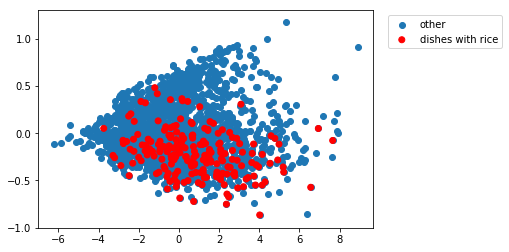

In [43]:
output = embedder.predict(dataset)
points = pca.transform(output)
x = [point[0] for point in points] 
y = [point[1] for point in points] 
plt.scatter(x,y, label="other")

output = embedder.predict(rice_dataset)
points = pca.transform(output)
x = [point[0] for point in points] 
y = [point[1] for point in points] 
colors = [[1, 0, 0]] * len(points)
plt.scatter(x,y, c=colors, label="dishes with rice")

plt.legend(bbox_to_anchor=(1.4, 1))
plt.show()

## Feature Reduction using t-SNE

### Plot all dishes

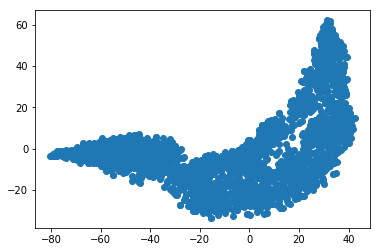

In [44]:
output = embedder.predict(dataset)
points = TSNE(n_components=2, random_state=4242).fit_transform(output)
x = [point[0] for point in points] 
y = [point[1] for point in points] 
plt.scatter(x,y)

### Plot dishes for cuisine

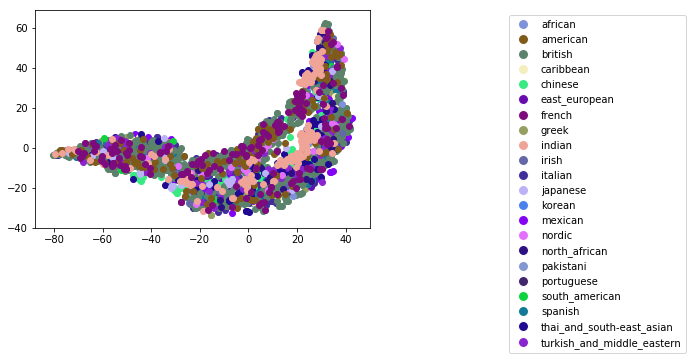

In [45]:
cuisines = ["african", "american",  "british", "caribbean",
           "chinese", "east_european", "french", "greek",
           "indian", "irish", "italian", "japanese",
           "korean", "mexican", "nordic", "north_african",
           "pakistani", "portuguese", "south_american",
           "spanish", "thai_and_south-east_asian",
           "turkish_and_middle_eastern"]

map_color = {}
for cuisine in cuisines:
    color = np.random.rand(3)
    map_color[cuisine] = color
    
legend_elements = []
for i in map_color:
    legend_elements.append(Line2D([0], [0], 
                                  marker='o', 
                                  color="w",
                                  label=i,
                                  markerfacecolor=map_color[i],
                                  markersize=10))

for p, label in zip(points, labels):
    plt.scatter(p[0], p[1], c=[map_color[label]])
plt.legend(handles=legend_elements, bbox_to_anchor=(1.4, 1))
plt.show()

# Analogies verification

In [47]:

# Compute the vector for each cuisine as the mean 
# of the dense vectors of all the dishes belonging 
# to that cuisine
cuisine_vectors = {}
for cuisine in dishes:
    matrix = []
    for dish in dishes[cuisine]:
        matrix.append(dishes[cuisine][dish])
    embedded = embedder.predict(np.array(matrix, dtype='int32'))
    cuisine_vectors[cuisine] = np.mean(embedded, axis=0)
    
    
# Compute the dense vectors for each dish and 
# for each cuisine available
embedded_dishes = {} # same structure as dishes with the dense vector instead of the sparse ones
for cuisine in dishes:
    embedded_dishes[cuisine] = {}
    for dish in dishes[cuisine]:
        embedded_dishes[cuisine][dish] = embedder.predict(np.array([dishes[cuisine][dish]], dtype='int32'))[0]
        

## Suggestion implementation (recepies information only)

In [48]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    #index_min = np.argmin(dist_2)
    index_min = np.argmax(cosine_similarity([node], nodes)[0])
    sim = cosine_similarity([node], [nodes[index_min]])
    return index_min, sim[0][0]
    #return np.argmin(dist_2), math.sqrt(dist_2[np.argmin(dist_2)])

origin_cuisine = "thai_and_south-east_asian"
origin_dish = "Beef rendang with herby rice "
destination_cuisine = "italian"

pasta = embedded_dishes[origin_cuisine][origin_dish]
italy = cuisine_vectors[origin_cuisine]
indian = cuisine_vectors[destination_cuisine]

info = np.subtract(pasta, italy)
recommendation = np.add(indian, info)

matrix = []
for dish in embedded_dishes[destination_cuisine]:
    matrix.append(embedded_dishes[destination_cuisine][dish])
matrix = np.array(matrix)


index, similarity = closest_node(recommendation, matrix) 

print("With distance ", similarity, " the suggestion is:  ", end="")
for name, vector in embedded_dishes[destination_cuisine].items():
    if np.array_equal(vector, matrix[index]):
        print(colored(name, 'blue', attrs=['bold']))
        break



[[1.317673   1.0548654  1.3504273  ... 1.1027167  1.0627639  0.9297503 ]
 [1.1743045  1.2177649  1.1898019  ... 0.84781    1.0153023  1.0181125 ]
 [0.9022709  0.9199739  1.0082965  ... 0.86705154 0.87443864 0.903828  ]
 ...
 [1.0403198  1.0717207  1.1213377  ... 0.95772266 0.79603344 0.89241934]
 [1.5820215  1.3465469  1.1235915  ... 1.2121351  1.4271469  1.2228295 ]
 [1.2041044  1.0438291  0.8583909  ... 0.9883107  0.96181995 1.0417522 ]]
With distance  0.99387723  the suggestion is:  Artichokes alla Romana


In [ ]:


# Plot origin_cuisine, origin_dish, destination_cuisine, recommendation and the nearest dish
d1 = pca.transform([pasta])[0]
plt.scatter(d1[0], d1[1], c='b', label="d1")

d2 = pca.transform([vector])[0]
plt.scatter(d2[0], d2[1], c='m', label="d2")

c1 = pca.transform([italy])[0]
plt.scatter(c1[0], c1[1], c='k', label="c1")

c2 = pca.transform([indian])[0]
plt.scatter(c2[0], c2[1], c='g', label="c2")

r = pca.transform([recommendation])[0]
plt.scatter(r[0], r[1], c='r', label="r")



plt.legend()
plt.show()


## Menu 
### print the list of possible dishes for each cuisine

In [17]:
print("Possible choices: ")

for cuisine in dishes:
    print("\n\n\nThe disches available for the cuisine ", colored(cuisine, 'blue', attrs=['bold']), " are:")
    for dish in dishes[cuisine]:
        print(dish, end=colored(" - ", 'red', attrs=['bold']))

Possible choices: 



The disches available for the cuisine  korean  are:
Korean-inspired turkey bowl - Korean fried chicken - Korean grilled beef short ribs (galbi gui) - Korean bulgogi chicken stir-fry - 


The disches available for the cuisine  italian  are:
How to make spaghetti Bolognese - New potato, spinach and goats’ cheese frittata - Tagliatelle with mushrooms and pancetta - One pan saltimbocca alla Romana - Lemon sorbet - Rhubarb panna cotta with roasted rhubarb - Spaghetti carbonara - Gluten-free almond biscuits - Prosciutto and pesto chicken thighs - Spring minestrone soup with pesto - Pasta primavera - Sardine and kale spaghetti - Spicy sausage pasta - Lamb cutlets with mint, chilli and golden potatoes - Spaghetti puttanesca - Chocolate pasta with caramel and pecans - Easy spaghetti vongole - Creamy chilli, bacon and tomato spaghetti - Spaghetti alla carbonara - Really easy mushroom risotto - Chicken and pea risotto - Salmon, fennel and pea risotto - One-step no-churn coff

## Suggestion implementation (recepies + image information)

In [ ]:
# Creating the multimodal embedding
path_emb_im = "./data/im_embeddings/"
path_emb_re = "./re_embeddings/"

for file in glob.glob(path_emb_re + "*.csv"):
    cuisine_csv = file.split("/")[-1]
    f = open("./data/embeddings/" + cuisine_csv, "w")
    
    re = open(file)
    
    dic_re = {}
    for line in re:
        line = line.replace("\n", "")
        line = line.split("; ")
        name = line[0]
        #emb = [float(v) for v in line[1:]]
        dic_re[name] = str(";".join(line[1:])).replace(" ", "")
        
    
    dic_im = {}
    im = open(path_emb_im + "embedding_" + cuisine_csv)
    for line in im:
        line = line.replace("\n", "")
        line = line.split("; ")
        name = str(line[0]).split(".")[0]
        #emb = [float(v) for v in line[1:]]
        dic_im[name] = str(";".join(line[1:])).replace(" ", "")
        
    for key in dic_re:
        v_im = dic_im[key]
        v_re = dic_re[key]
        
        f.write(key + ";" + v_re + ";" + v_im + "\n")

In [53]:
def search_dish_vector(dish, file):
    with open(file) as f:
        for line in f:
            name = line.split(";")[0]
            if name.replace(" ", "") == dish.replace(" ", ""):
                vec = [float(v) for v in line.split(";")[1:]]
                return np.array(vec)
    print("[ERROR] origin dish (",dish,") or cuisine not found!", file=sys.stderr)
    print("__________________________________________________________", file=sys.stderr)
    return None


def get_cuisine_vector(file):
    _sum = None
    with open(file) as f:
        count = 0
        for line in f:
            vec = np.array([float(v) for v in line.split(";")[1:]])
            if _sum is None:
                _sum = vec
                count += 1
            else:
                _sum = _sum + vec
                count += 1
    return _sum / count


def get_dishes_matrix(file, filters=None, filters_path=""):
    matrix = []
    cuisine = file.split("/")[-1].split(".")[0]
    with open(file) as f:
        for line in f:
            vec = np.array([float(v) for v in line.split(";")[1:]])

            to_be_add = True
            if filters is not None and filters != []:
                to_be_add = False
                name = line.split(";")[0]
                for filter in filters:
                    with open(filters_path + filter + ".csv", 'r') as filter_file:
                        content = filter_file.read()
                        if cuisine + ";" + name in content:
                            to_be_add = True
                            continue

            if to_be_add:
                matrix.append(vec)

    return np.array(matrix)


def search_dish_name(vector, file):
    with open(file) as f:
        for line in f:
            vec = np.array([float(v) for v in line.split(";")[1:]])
            if np.array_equal(vec, vector):
                return str(line.split(";")[0])


def closest_node(node, nodes, num_of_suggestion):
    nodes = np.asarray(nodes)
    sim_vec = cosine_similarity([node], nodes)[0]
    indexes = sim_vec.argsort()[-num_of_suggestion:][::-1]

    similarities = []
    for i in indexes:
        sim = cosine_similarity([node], [nodes[i]])
        similarities.append(sim)
    return zip(indexes, similarities)


def get_urls_dict(urls_path):
    urls_dict = {}
    with open(urls_path) as file:
        for line in file:
            name = line.split(";")[0]
            link = line.split(";")[1]
            urls_dict[name] = link.replace("\n", "")
    return urls_dict

    
        

In [33]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    print(nodes.shape)
    print(node.shape)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    index_min = np.argmax(cosine_similarity([node], nodes)[0])
    sim = cosine_similarity([node], [nodes[index_min]])
    return index_min, sim[0][0]

for

emb_path = "/home/umberto/Desktop/data/embeddings/"
estension = ".csv"
origin_cuisine = "thai_and_south-east_asian"
origin_dish = "Beef rendang with herby rice "
destination_cuisine = "italian"

dish = search_dish_vector(origin_dish, emb_path + origin_cuisine + estension)
orig = get_cuisine_vector(emb_path + origin_cuisine + estension)
dest = get_cuisine_vector(emb_path + destination_cuisine + estension)

info = np.subtract(dish, orig)
recommendation = np.add(dest, info)

matrix = get_dishes_matrix(emb_path + destination_cuisine + estension)
index, similarity = closest_node(recommendation, matrix) 

print("With distance ", similarity, " the suggestion is:  ", end="")
name = search_dish_name(matrix[index], emb_path + destination_cuisine + estension)
print(colored(name, 'blue', attrs=['bold']))




(266, 1074)
(1074,)
With distance  0.7298130799898706  the suggestion is:  Espresso martini tiramisu


# Coverage Computation
### This is able to compute the coverage for each cuisine, keep in mind that require 2 hours to be computed

In [55]:
def search_dish_vector(dish, file):
    with open(file) as f:
        for line in f:
            name = line.split(";")[0]
            if name.replace(" ", "") == dish.replace(" ", ""):
                vec = [float(v) for v in line.split(";")[1:]]
                return np.array(vec)
    print("[ERROR] origin dish (",dish,") or cuisine not found!", file=sys.stderr)
    print("__________________________________________________________", file=sys.stderr)
    return None


def get_cuisine_vector(file):
    _sum = None
    with open(file) as f:
        count = 0
        for line in f:
            vec = np.array([float(v) for v in line.split(";")[1:]])
            if _sum is None:
                _sum = vec
                count += 1
            else:
                _sum = _sum + vec
                count += 1
    return _sum / count


def get_dishes_matrix(file, filters=None, filters_path=""):
    matrix = []
    cuisine = file.split("/")[-1].split(".")[0]
    with open(file) as f:
        for line in f:
            vec = np.array([float(v) for v in line.split(";")[1:]])

            to_be_add = True
            if filters is not None and filters != []:
                to_be_add = False
                name = line.split(";")[0]
                for filter in filters:
                    with open(filters_path + filter + ".csv", 'r') as filter_file:
                        content = filter_file.read()
                        if cuisine + ";" + name in content:
                            to_be_add = True
                            continue

            if to_be_add:
                matrix.append(vec)

    return np.array(matrix)


def search_dish_name(vector, file):
    with open(file) as f:
        for line in f:
            vec = np.array([float(v) for v in line.split(";")[1:]])
            if np.array_equal(vec, vector):
                return str(line.split(";")[0])


def closest_node(node, nodes, num_of_suggestion):
    nodes = np.asarray(nodes)
    sim_vec = cosine_similarity([node], nodes)[0]
    indexes = sim_vec.argsort()[-num_of_suggestion:][::-1]

    similarities = []
    for i in indexes:
        sim = cosine_similarity([node], [nodes[i]])
        similarities.append(sim)
    return zip(indexes, similarities)


def get_urls_dict(urls_path):
    urls_dict = {}
    with open(urls_path) as file:
        for line in file:
            name = line.split(";")[0]
            link = line.split(";")[1]
            urls_dict[name] = link.replace("\n", "")
    return urls_dict


In [61]:
def apply_analogy(origin_cuisine,
                  origin_dish,
                  destination_cuisine,
                  data_path = "./data/",
                  num_of_suggestion=3,
                  filters=None
                  ):
    """
    :param origin_cuisine: the cuisine known by the user
    :param origin_dish: the dish that the user like
    :param destination_cuisine: the cuisine for which the recommendation have to be computed
    :param data_path: the path to the folder "data"
    :param num_of_suggestion: the number of dished to be suggested
    :param filters: list of the filter that have to be applied
    :return: a list of lists with the following structure:
            [[<name of the 1° suggested dish>, <confidence>, <directory of the images>, <url to the recipe>], ....]
    """

    emb_path =    data_path + "embeddings/"
    images_path = data_path + "DatasetImages/"
    urls_path =   data_path + "urls.csv"
    filers_path = data_path + "Filters/"
    estension = ".csv"


    origin_cuisine = emb_path + origin_cuisine + estension
    destination_name = destination_cuisine
    destination_cuisine = emb_path + destination_cuisine + estension

    dish = search_dish_vector(origin_dish, origin_cuisine)
    orig = get_cuisine_vector(origin_cuisine)
    dest = get_cuisine_vector(destination_cuisine)


    info = np.subtract(dish, orig)
    recommendation = np.add(dest, info)

    matrix = get_dishes_matrix(destination_cuisine, filters, filers_path)
    points = closest_node(recommendation, matrix, num_of_suggestion)

    result = []

    urls_dict = get_urls_dict(urls_path)

    count = 1
    for index, sim in points:
        #print("With confidence ", sim[0][0], " the " + str(count) + "° suggestion is:  ", end="")
        name = search_dish_name(matrix[index], destination_cuisine)
        #print(colored(name, 'blue', attrs=['bold']))
        count += 1
        result.append([name, sim[0][0], images_path + destination_name + "/" + name + ".jpg", urls_dict[name]])

    return result

In [63]:
for dest in dishes:
    dish_recc = {}
    for origin in dishes:
        print(origin, end="; ")
        if origin != dest:
            for dish in dishes[origin]:
                three_recs=apply_analogy(
                                origin_cuisine=origin,
                                origin_dish=dish,
                                destination_cuisine=dest,
                                data_path = "./CuisineClassifying/data/",
                            )
                for rec in three_recs:
                    name = rec[0] 
                    if name in dish_recc:
                        dish_recc[name] += 1
                    else:
                        dish_recc[name] = 1
    print("\n")
    print("From the ", len(dishes[dest]), 
          "dishes available for the cuisine", 
          dest, "only ", len(dish_recc), 
          "where recommended.")
    print("\t The relative coverage is:", len(dish_recc)/len(dishes[dest]))
                    
        

korean; italian; mexican; pakistani; portuguese; greek; east_european; chinese; spanish; caribbean; british; african; south_american; thai_and_south-east_asian; turkish_and_middle_eastern; nordic; irish; japanese; north_african; american; indian; french; 

From the  4 dishes available for the cuisine korean only  4 where recommended.
	 The relative coverage is: 1.0
korean; italian; mexican; pakistani; portuguese; greek; east_european; chinese; spanish; caribbean; british; african; south_american; thai_and_south-east_asian; turkish_and_middle_eastern; nordic; irish; japanese; north_african; american; indian; french; 

From the  266 dishes available for the cuisine italian only  262 where recommended.
	 The relative coverage is: 0.9849624060150376
korean; italian; mexican; pakistani; portuguese; greek; east_european; chinese; spanish; caribbean; british; african; south_american; thai_and_south-east_asian; turkish_and_middle_eastern; nordic; irish; japanese; north_african; american; india